## Benchmark analysis across different curvatures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hyperdt.wrapped_normal_all_curvature import WrappedNormalMixture
from hyperdt.all_curvature_DT import HyperspaceDecisionTree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

INFO: Using numpy backend


In [3]:
def Minkowski_dot_product(v1, v2):
    return v1 @ v2 - 2 * v1[0] * v2[0]

### Experiments across different curvatures:
1. HyperDT accuracy vs. sklearn

2. Distribution of distances from cluster means

3. Pairwise distances in each cluster

In [4]:
NUM_CLASSES = 5
N_DIM = 2
curvatures = [-4, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 4]
rnd_seeds = [0, 1, 2, 10, 42, 123, 137, 1234, 12345]

In [5]:
def compute_scores(curvature, seed, num_classes=NUM_CLASSES, n_dim=N_DIM, cov_scale=0.3):
    # Generate data
    hyp = WrappedNormalMixture(num_points=1000, num_classes=num_classes, n_dim=n_dim, curvature=curvature,
                               seed=seed, cov_scale=cov_scale)
    X_hyp, y_hyp, X_hyp_means = hyp.generate_data()

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_hyp, y_hyp, test_size=0.2, random_state=seed)

    # Fit hyperspace decision tree classifier
    hypdt = HyperspaceDecisionTree(max_depth=5, signed_curvature=curvature)
    hypdt.fit(X_train, y_train)
    hypdt_score = hypdt.score(X_test, y_test)

    # Fit sklearn's decision tree classifier
    dt = DecisionTreeClassifier(max_depth=5)
    dt.fit(X_train, y_train)
    dt_score = dt.score(X_test, y_test)

    return hypdt_score, dt_score

In [6]:
hypdt_scores_by_curvature = []
dt_scores_by_curvature = []

for curvature in curvatures:
    hypdt_scores = []
    dt_scores = []
    for seed in rnd_seeds:
        hypdt_score, dt_score = compute_scores(curvature, seed)
        hypdt_scores.append(hypdt_score)
        dt_scores.append(dt_score)
    hypdt_scores_by_curvature.append(hypdt_scores)
    dt_scores_by_curvature.append(dt_scores)

### 1. Plot comparative accuracies for different curvatures

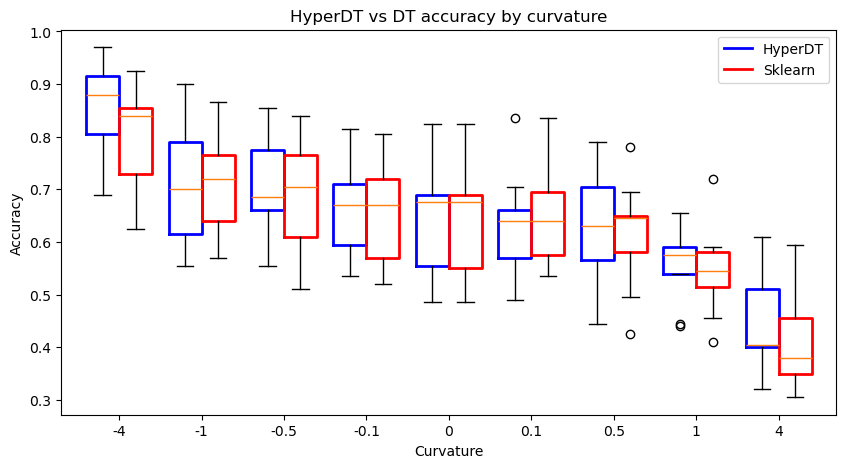

In [7]:
# Plot boxplots of scores across random seeds and curvatures, with each boxplot representing a different curvature
plt.figure(figsize=(10, 5))
boxprops_hyperdt = dict(color='blue', linewidth=2)
boxprops_sklearn = dict(color='red', linewidth=2)
bp1 = plt.boxplot(hypdt_scores_by_curvature, positions=np.arange(len(curvatures)) - 0.2, widths=0.4, boxprops=boxprops_hyperdt)
bp2 = plt.boxplot(dt_scores_by_curvature, positions=np.arange(len(curvatures)) + 0.2, widths=0.4, boxprops=boxprops_sklearn)
plt.xticks(range(len(curvatures)), curvatures)
plt.xlabel('Curvature')
plt.ylabel('Accuracy')
plt.title('HyperDT vs DT accuracy by curvature')
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['HyperDT', 'Sklearn'])
# plt.savefig('plots/hyperdt_vs_dt_accuracy_by_curvature.png')
plt.show()

### 2. Plot distribution of distances from cluster means for different curvatures

In [8]:
def compute_dists(curvature, seed, num_classes=NUM_CLASSES, n_dim=N_DIM, cov_scale=0.3):
    # Generate data
    hyp = WrappedNormalMixture(num_points=1000, num_classes=num_classes, n_dim=n_dim, curvature=curvature, 
                               seed=seed, cov_scale=cov_scale)
    X_hyp, y_hyp, X_hyp_means = hyp.generate_data()

    # Distribution of distances from cluster centers
    dists = []
    for x, idx in zip(X_hyp, y_hyp):
        class_mean = X_hyp_means[idx]
        if c < 0:
            dists.append(np.arccosh(c * Minkowski_dot_product(x, class_mean)) / np.sqrt(abs(c)))
        elif c > 0:
            dists.append(np.arccos(c * np.dot(x, class_mean)) / np.sqrt(abs(c)))
        else:
            dists.append(np.linalg.norm(x - class_mean))

    # Compute average pairwise distance in each cluster
    avg_pairwise_dists = []
    for i in range(NUM_CLASSES):
        cluster = X_hyp[y_hyp == i]
        avg_pairwise_dists.append(np.mean([np.linalg.norm(cluster[j] - cluster[k])
                                        for j in range(len(cluster)) for k in range(j+1, len(cluster))]))

    return dists, avg_pairwise_dists

In [9]:
dists_by_curvature = []
pair_dists_by_curvature = []

for c in curvatures:
    dists, avg_pairwise_dists = compute_dists(c, seed=0)
    dists_by_curvature.append(dists)
    pair_dists_by_curvature.append(avg_pairwise_dists)

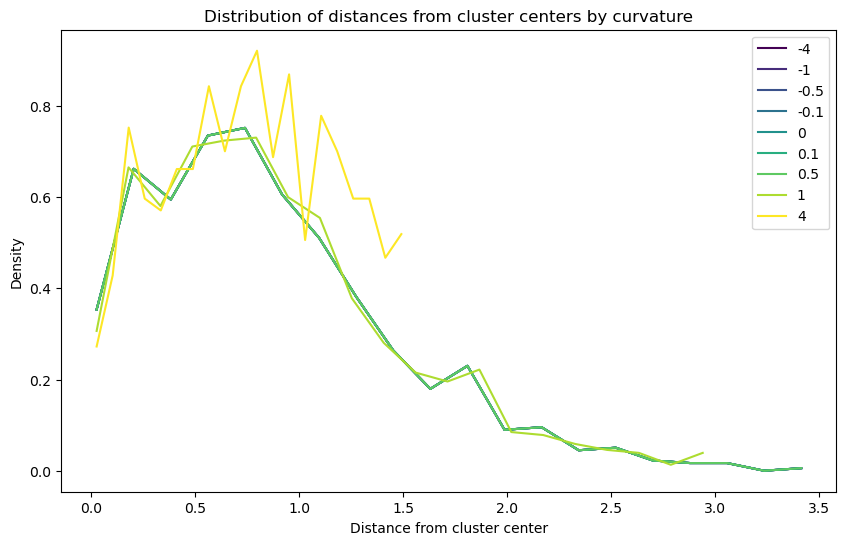

In [10]:
colors = plt.cm.viridis(np.linspace(0, 1, len(curvatures)))
fig = plt.figure(figsize=(10, 6))
for i in range(len(curvatures)):
    hist = np.histogram(dists_by_curvature[i], bins=20, density=True)
    plt.plot(hist[1][:-1], hist[0], label=f"{curvatures[i]}", color=colors[i])
plt.legend()
plt.xlabel('Distance from cluster center')
plt.ylabel('Density')
plt.title('Distribution of distances from cluster centers by curvature')
# plt.savefig('plots/distribution_of_distances_from_cluster_centers_by_curvature.png')
plt.show()

### 3. Plot pairwise distances in each cluster

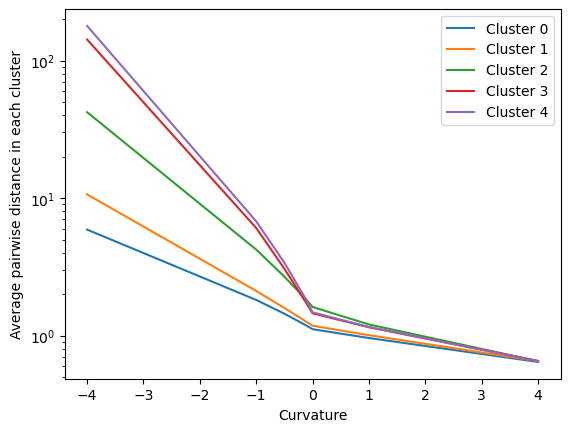

In [11]:
# Plot average pairwise distances in each cluster by curvature
plt.plot(curvatures, pair_dists_by_curvature)
plt.yscale('log')
plt.xlabel('Curvature')
plt.ylabel('Average pairwise distance in each cluster')
plt.legend([f'Cluster {i}' for i in range(NUM_CLASSES)])
# plt.savefig('plots/average_pairwise_distance_in_each_cluster_by_curvature.png')
plt.show()